**Question**: Can a predictive model be built using leaf morphology classifications that may indicate that a particular genotype was cultivated in a “drought” or “control” condition?

In [36]:
import pickle
import numpy as np
import pandas as pd
from pathlib import Path
from openpyxl import Workbook
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
HOME_DIR = str(Path().cwd().parent)
RANDOM_SEED = 445

# get the sheet data (this time with the predicted stuff)
SHEET_DATA = pd.read_excel(f'{HOME_DIR}/step2/data.xlsx')
SHEET_DATA.head()

,filename,treatment,block,row,position,genotype,leaf_color,leaf_shape,brown_splotches
0,EB00CEE6-848F-4E2A-9A56-C0CD83D55630.jpg,D,1.0,8.0,32.0,BESC-34,light_green,ovate,none
1,5AF900F9-D701-4994-95AC-2352420BF18F.jpg,C,1.0,10.0,12.0,"**BESC-417_LM**,core",yellow_green,ovate,high
2,F7D01515-92CA-4AF5-9BD9-3A4CD99EDF42.jpg,C,2.0,3.0,40.0,BESC-468,yellow,lanceolate,high
3,9117861B-2D2B-4EA8-94B1-D0A862914398.jpg,C,2.0,6.0,54.0,BESC-28_LM,dark_green,ovate,low
4,D1B282CF-2A10-4458-9E3A-FE08E065A3D6.jpg,C,1.0,24.0,22.0,"**LILD-26-5_LM**,core",yellow_green,lanceolate,medium


#### Filter null leaf attributes and treatments

In [3]:
FILTERED_SHEET_DATA = SHEET_DATA[pd.notna(SHEET_DATA['leaf_shape'])]
FILTERED_SHEET_DATA = FILTERED_SHEET_DATA[pd.notna(FILTERED_SHEET_DATA['treatment'])]
FILTERED_SHEET_DATA.info()

<class 'pandas.core.frame.DataFrame'>
Index: 983 entries, 0 to 1671
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   filename         983 non-null    object 
 1   treatment        983 non-null    object 
 2   block            965 non-null    float64
 3   row              956 non-null    float64
 4   position         956 non-null    float64
 5   genotype         946 non-null    object 
 6   leaf_color       983 non-null    object 
 7   leaf_shape       983 non-null    object 
 8   brown_splotches  983 non-null    object 
dtypes: float64(3), object(6)
memory usage: 76.8+ KB


#### Transform data to something to feed to a classifier

In [4]:
def transform_data(df: pd.DataFrame) -> pd.DataFrame:
    encoded_info = pd.get_dummies(df, columns=['leaf_color', 'leaf_shape'], dtype=int)
    training_data = encoded_info.drop(columns=['filename', 'block', 'row', 'position', 'genotype'])
    browns = list(training_data.pop("brown_splotches"))
    for i in range(len(browns)):
        browns[i] = ['none', 'low', 'medium', 'high'].index(browns[i])
    return pd.DataFrame({"brown_splotches": browns} | dict(training_data))

training_data = transform_data(FILTERED_SHEET_DATA)
training_data.head()

,brown_splotches,treatment,leaf_color_dark_green,leaf_color_light_green,leaf_color_yellow,leaf_color_yellow_green,leaf_shape_elliptical,leaf_shape_lanceolate,leaf_shape_oblong,leaf_shape_ovate
0,0,D,0,1,0,0,0,0,0,1
1,3,C,0,0,0,1,0,0,0,1
2,3,C,0,0,1,0,0,1,0,0
3,1,C,1,0,0,0,0,0,0,1
4,2,C,0,0,0,1,0,1,0,0


#### Train classifier on the data

In [37]:
# make sure classes are even by randomly pruning data
def preprocess(df: pd.DataFrame) -> pd.DataFrame:
    np.random.seed(RANDOM_SEED)
    control = df[df['treatment'] == 'C']
    drought = df[df['treatment'] == 'D']
    n = len(drought) - len(control)
    if n == 0: return df
    elif n > 0:
        drop_indeces = np.random.choice(drought.index, n, replace=False)
        return pd.concat([drought.drop(drop_indeces), control], ignore_index=True)
    else:
        drop_indeces = np.random.choice(control.index, -n, replace=False)
        return pd.concat([control.drop(drop_indeces), drought], ignore_index=True)

# get training and testing data
df = preprocess(training_data.copy())
y_col = [*map(lambda x: x == 'D', df.pop('treatment'))]     # true if in drought condiiton
X_train, X_test, y_train, y_test = train_test_split(df, y_col, test_size=0.60, random_state=RANDOM_SEED)

# train the model and save
model = RandomForestClassifier(class_weight="balanced", random_state=RANDOM_SEED)
model.fit(X_train, y_train)
with open(f"model.pkl", "wb") as f:
    pickle.dump(model, f)

y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2%}")

Accuracy: 60.08%


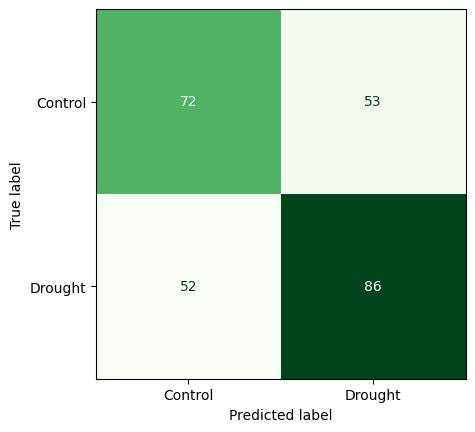

In [38]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["Control", "Drought"])
disp.plot(cmap="Greens", colorbar=False)
plt.show()

#### Adjust data in the spreadsheet to have the treatments predicted

In [278]:
with open("model.pkl", "rb") as f:
    model = pickle.load(f)

# gets predictions for availble values
no_treatment = SHEET_DATA[SHEET_DATA["treatment"].isnull()]
pred_available = no_treatment[pd.notna(no_treatment["leaf_shape"])]
transformed = transform_data(pred_available).drop(columns=["treatment"])
predictions = model.predict(transformed)

# edit sheet data
new_sheet_data = SHEET_DATA.copy()
for index, pred in zip(pred_available.index, predictions):
    new_sheet_data.at[index, 'treatment'] = ['C*', 'D*'][pred]
new_sheet_data.head()

/var/folders/63/y2x5gxv51613j8s95jwnpddw0000gn/T/ipykernel_1476/3203488776.py:13: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  new_sheet_data.at[index, 'treatment'] = ['C*', 'D*'][pred]


,filename,treatment,block,row,position,genotype,leaf_color,leaf_shape,brown_splotches
0,EB00CEE6-848F-4E2A-9A56-C0CD83D55630.jpg,D,1.0,8.0,32.0,BESC-34,light_green,ovate,none
1,5AF900F9-D701-4994-95AC-2352420BF18F.jpg,C,1.0,10.0,12.0,"**BESC-417_LM**,core",yellow_green,ovate,high
2,F7D01515-92CA-4AF5-9BD9-3A4CD99EDF42.jpg,C,2.0,3.0,40.0,BESC-468,yellow,lanceolate,high
3,9117861B-2D2B-4EA8-94B1-D0A862914398.jpg,C,2.0,6.0,54.0,BESC-28_LM,dark_green,ovate,low
4,D1B282CF-2A10-4458-9E3A-FE08E065A3D6.jpg,C,1.0,24.0,22.0,"**LILD-26-5_LM**,core",yellow_green,lanceolate,medium


In [279]:
def make_sheet(data: pd.DataFrame, excel_file: str) -> None:
    wb = Workbook()
    worksheet = wb.active
    
    # For writing the Header Rows on Excel
    headers = [*data.keys()]
    worksheet.append(headers)

    # For writing the data rows for each image in the dataset
    for i in range(len(data)):
        row = [data[header][i] for header in headers]
        worksheet.append(row)

    wb.save(excel_file)
        
make_sheet(new_sheet_data, 'data.xlsx')